## Necessary Imports

In [2]:
import os
import glob

import numpy as np
import torch

from scipy.ndimage import affine_transform, zoom

In [3]:
import cv2
from PIL import Image

## Visualizing

### Rotations

In [4]:
class Log_Images:
    def __init__(
        self,
        # fabric: L.Fabric,
        config,
        writer=None,
    ):
        self.wandb_on = config.wandb_on
        self.pretrained = config.pretrained
        self.model_name = config.model_name
        self.nr_of_classes = config.nr_of_classes
        self.writer = writer
        if self.model_name == 'simple_unet':
            self.image_shape = (160,192)
        else:
            self.image_shape = (162,194)

        # color map to get always the same colors for classes
        if config.nr_of_classes in [2,6,16,50,106]: # freesurfer colors available
            colors = self.__rgb_map_for_data(config.nr_of_classes)
        else:
            colors = plt.cm.hsv(np.linspace(0, 1, config.nr_of_classes))
            colors = colors[:,:-1] * 255
        self.color_range = np.zeros((256,3))
        self.color_range[:colors.shape[0],:] = colors

        # load always the same image from validation set
        image_file = "pac_36_orig.nii.gz"
        mask_file = "pac_36_aseg.nii.gz"
        file_path = "/om2/user/matth406/nobrainer_data/data/SharedData/segmentation/freesurfer_asegs/"
        brain, mask, _ = load_brains(image_file, mask_file, file_path)
        mask = mapping(mask,nr_of_classes=self.nr_of_classes)

        self.brain_slices, self.mask_slices = [], []

        # randomly select slices in 3 directions
        self.slice_idx = [125, 150]
        normalization_constants = np.load(
            "/om2/user/matth406/nobrainer_data_norm/data_prepared_medium/normalization_constants.npy"
        )
        self.brain_slices = torch.empty((len(self.slice_idx) * 3, 1, self.image_shape[0], self.image_shape[1]))
        self.mask_slices = torch.empty((len(self.slice_idx) * 3, 1, self.image_shape[0], self.image_shape[1]),dtype=torch.long)
        i = 0
        self.logging_dict = {}
        for d in range(3):
            for slice_id in self.slice_idx:
                if d == 0:
                    brain_slice = crop(brain[slice_id, :, :], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[slice_id, :, :], self.image_shape[0], self.image_shape[1])
                if d == 1:
                    brain_slice = crop(brain[:, slice_id, :], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[:, slice_id, :], self.image_shape[0], self.image_shape[1])
                if d == 2:
                    brain_slice = crop(brain[:, :, slice_id], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[:, :, slice_id], self.image_shape[0], self.image_shape[1])

                self.logging_dict[f"Image d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on, brain_slice, caption="Raw Image",#fig_path=f'/om2/user/sabeen/test_imgs/raw_d{d}_c{slice_id}_fs.png'
                )
                self.logging_dict[f"True Mask d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on,
                    mask_slice,
                    caption="True Mask",
                    color_range=self.color_range,
                    # fig_path=f'/om2/user/sabeen/test_imgs/true_mask_d{d}_c{slice_id}_fs.png'
                )
                brain_slice = (
                    brain_slice - normalization_constants[0]
                ) / normalization_constants[1]
                brain_slice = torch.from_numpy(brain_slice).to(torch.float32)
                brain_slice = brain_slice[None, None]
                self.brain_slices[i] = brain_slice

                mask_slice = torch.tensor(mask_slice)[None, None].long()
                self.mask_slices[i] = mask_slice

                i += 1

        # send all slices to device
        if self.pretrained:
            self.brain_slices = self.brain_slices.repeat((1, 3, 1, 1))
        self.brain_slices = fabric.to_device(self.brain_slices)
        self.mask_slices = fabric.to_device(self.mask_slices)

    @torch.no_grad()
    def logging(self, model, epoch: int, commit: bool):
        model.eval()
        probs = model(self.brain_slices)
        probs = probs.argmax(1)
        probs = probs.cpu()
        model.train()

        i = 0
        logging_dict = {}
        for d in range(3):
            for slice_id in self.slice_idx:
                logging_dict[f"Predicted Mask d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on,
                    probs[i].numpy(),
                    caption=f"Epoch {epoch}",
                    color_range=self.color_range,
                    # fig_path=f'/om2/user/sabeen/test_imgs/predicted_mask_d{d}_c{slice_id}_fs.png'
                )
                i += 1
        current_logging_dict = self.logging_dict | logging_dict
        if self.wandb_on:
            wandb.log(current_logging_dict, commit=commit)
        
        if self.writer is not None:
            print('Logging images...')
            # only log raw image and true mask once
            if epoch == 1:
                for key, img in self.logging_dict.items():
                    img = np.array(img)
                    if len(img.shape) == 3:
                        self.writer.add_image(key, np.array(img), epoch, dataformats='HWC')
                    elif len(img.shape) == 2:
                        self.writer.add_image(key, np.array(img), epoch, dataformats='HW')
            
            # log predicted masks each time
            for key, img in logging_dict.items():
                img = np.array(img)
                if len(img.shape) == 3:
                    self.writer.add_image(key, np.array(img), epoch, dataformats='HWC')
                elif len(img.shape) == 2:
                    self.writer.add_image(key, np.array(img), epoch, dataformats='HW')
    

def __create_plot(
    wandb_on,
    image: np.array,
    caption: str,
    color_range = None,
    fig_path: str = None,
):
    if fig_path is not None and len(fig_path.split('.')) == 1:
        fig_path = fig_path + '.png'
        
    if color_range is not None:
        image = image.astype(np.uint8)
        channels = [cv2.LUT(image, color_range[:,i]) for i in range(3)]
        new_img = np.dstack(channels)
    
        if fig_path is not None:
            new_img_bgr = np.dstack([channels[2],channels[1],channels[0]])
            cv2.imwrite(fig_path,new_img_bgr)
        image = Image.fromarray(np.uint8(new_img))
    else:
        img_min = np.min(image)
        img_max = np.max(image)
        new_img = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        if fig_path is not None:
            cv2.imwrite(fig_path,new_img)
        image = Image.fromarray(np.uint8(new_img))
    if wandb_on:
            image = wandb.Image(image, caption=caption)
    return image
    
def __extract_numbers_names_colors(FreeSurferColorLUT=''):
    """
    Extract lists of numbers, names, and colors representing anatomical brain
    regions from FreeSurfer's FreeSurferColorLUT.txt lookup table file.

    Parameters
    ----------
    FreeSurferColorLUT : string
        full path to FreeSurferColorLUT.txt file (else uses local Python file)

    Returns
    -------
    numbers : list of integers
        numbers representing anatomical labels from FreeSurferColorLUT.txt
    names : list of integers
        names for anatomical regions from FreeSurferColorLUT.txt
    colors : list of integers
        colors associated with anatomical labels from FreeSurferColorLUT.txt

    Examples
    --------
    >>> from mindboggle.mio.labels import extract_numbers_names_colors # doctest: +SKIP
    >>> ennc = extract_numbers_names_colors # doctest: +SKIP
    >>> en1,en2,ec = ennc('/Applications/freesurfer/FreeSurferColorLUT.txt') # doctest: +SKIP

    """
    import os
    from io import open

    # from ext.mindboggle.FreeSurferColorLUT import lut_text

    def is_number(s):
        try:
            int(s)
            return True
        except ValueError:
            return False

    # if os.environ['FREESURFER_HOME']:
    #     FreeSurferColorLUT = os.path.join(
    #              os.environ['FREESURFER_HOME'], 'FreeSurferColorLUT.txt')

    if FreeSurferColorLUT and os.path.exists(FreeSurferColorLUT):
        f = open(FreeSurferColorLUT, 'r')
        lines = f.readlines()
    # else:
    #     lut = lut_text()
    #     lines = lut.split('\n')

    numbers = []
    names = []
    colors = []
    for line in lines:
        strings = line.split()
        if strings and is_number(strings[0]):
            numbers.append(int(strings[0]))
            names.append(strings[1])
            colors.append([int(strings[2]), int(strings[3]),
                        int(strings[4])])

    return numbers, names, colors

def __rgb_map_for_data(nr_of_classes):
    _, fs_names, fs_colors = __extract_numbers_names_colors(
        "/om2/user/sabeen/freesurfer/distribution/FreeSurferColorLUT.txt"
    )

    with open("/om2/user/sabeen/readme", "r") as f:
        voxmorph_label_index = f.read().splitlines()

    # get the last 24 lines of the readme file (format--> id: name)
    if nr_of_classes == 50:
        voxmorph_label_index = [
            item.strip().split(":")
            for item in voxmorph_label_index[200:250]
            if item != ""
        ]  # HACK
    elif nr_of_classes == 106:
        voxmorph_label_index = [
            item.strip().split(":")
            for item in voxmorph_label_index[91:197]
            if item != ""
        ]  # HACK
    elif nr_of_classes == 6:
        voxmorph_label_index = [
            item.strip().split(":")
            for item in voxmorph_label_index[253:259]
            if item != ""
        ]  # HACK
    elif nr_of_classes == 2:
        voxmorph_label_index = [
            item.strip().split(":")
            for item in voxmorph_label_index[262:264]
            if item != ""
        ]  # HACK
    elif nr_of_classes == 16:
        voxmorph_label_index = [
            item.strip().split(":")
            for item in voxmorph_label_index[266:282]
            if item != ""
        ]  # HACK
    else:
        raise Exception(f"coloring for nr_of_classes = {nr_of_classes} not found")
    
    voxmorph_label_index = [
        [int(item[0]), item[1].strip()] for item in voxmorph_label_index
    ]
    voxmorph_label_index_dict = dict(voxmorph_label_index)
    my_colors = [
        fs_colors[fs_names.index(item)] for item in voxmorph_label_index_dict.values()
    ]

    return np.array(my_colors)

In [6]:
data_dir = '/om2/user/sabeen/nobrainer_data_norm/new_small_no_aug_51'
aug_dir = '/om2/user/sabeen/nobrainer_data_norm/20240205_test'
mode = 'test'

In [7]:
images = sorted(glob.glob(f"{data_dir}/{mode}/brain*.npy"))
masks = sorted(glob.glob(f"{data_dir}/{mode}/mask*.npy"))
affines = sorted(glob.glob(f"{aug_dir}/{mode}/affine*.npy"))

In [9]:
len(images) == len(masks) == len(affines)

False

In [10]:
colors = __rgb_map_for_data(51)
color_range = np.zeros((256,3))
color_range[:colors.shape[0],:] = colors

In [12]:
idx = 0
image = np.load(images[idx])
mask = np.load(masks[idx])
affine = np.load(affines[idx])

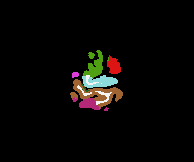

In [13]:
__create_plot(False,mask.squeeze().astype(np.uint8),'',color_range=color_range)

In [14]:
m = affine_transform(mask.squeeze().astype(np.uint8),affine,order=0)

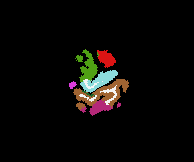

In [15]:
__create_plot(False,m,'',color_range=color_range)

In [142]:
torch.from_numpy(m).unsqueeze(dim=0).shape

(1, 162, 194)

In [34]:
def create_affine_transformation_matrix(
    n_dims, scaling=None, rotation=None, shearing=None, translation=None
):
    """
    From https://github.com/MGH-LEMoN/photo-reconstruction/blob/main/scripts/hcp_replicate_photos.py#L85C40-L85C40.
    Create a 4x4 affine transformation matrix from specified values
    :param n_dims: integer
    :param scaling: list of 3 scaling values
    :param rotation: list of 3 angles (degrees) for rotations around 1st, 2nd, 3rd axis
    :param shearing: list of 6 shearing values
    :param translation: list of 3 values
    :return: 4x4 numpy matrix
    """

    T_scaling = np.eye(n_dims + 1)
    T_shearing = np.eye(n_dims + 1)
    T_translation = np.eye(n_dims + 1)

    if scaling is not None:
        T_scaling[np.arange(n_dims + 1), np.arange(n_dims + 1)] = np.append(
            scaling, 1
        )

    if shearing is not None:
        shearing_index = np.ones((n_dims + 1, n_dims + 1), dtype="bool")
        shearing_index[np.eye(n_dims + 1, dtype="bool")] = False
        shearing_index[-1, :] = np.zeros((n_dims + 1))
        shearing_index[:, -1] = np.zeros((n_dims + 1))
        T_shearing[shearing_index] = shearing

    if translation is not None:
        T_translation[
            np.arange(n_dims), n_dims * np.ones(n_dims, dtype="int")
        ] = translation

    if n_dims == 2:
        if rotation is None:
            rotation = np.zeros(1)
        else:
            rotation = np.asarray(rotation) * (np.pi / 180)
        T_rot = np.eye(n_dims + 1)
        T_rot[np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])] = [
            np.cos(rotation[0]),
            np.sin(rotation[0]),
            np.sin(rotation[0]) * -1,
            np.cos(rotation[0]),
        ]
        return T_translation @ T_rot @ T_shearing @ T_scaling

    else:

        if rotation is None:
            rotation = np.zeros(n_dims)
        else:
            rotation = np.asarray(rotation) * (np.pi / 180)
        T_rot1 = np.eye(n_dims + 1)
        T_rot1[np.array([1, 2, 1, 2]), np.array([1, 1, 2, 2])] = [
            np.cos(rotation[0]),
            np.sin(rotation[0]),
            np.sin(rotation[0]) * -1,
            np.cos(rotation[0]),
        ]
        T_rot2 = np.eye(n_dims + 1)
        T_rot2[np.array([0, 2, 0, 2]), np.array([0, 0, 2, 2])] = [
            np.cos(rotation[1]),
            np.sin(rotation[1]) * -1,
            np.sin(rotation[1]),
            np.cos(rotation[1]),
        ]
        T_rot3 = np.eye(n_dims + 1)
        T_rot3[np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])] = [
            np.cos(rotation[2]),
            np.sin(rotation[2]),
            np.sin(rotation[2]) * -1,
            np.cos(rotation[2]),
        ]
        return T_translation @ T_rot3 @ T_rot2 @ T_rot1 @ T_shearing @ T_scaling

In [82]:
image = np.load(images[0]).squeeze()
mask = np.load(masks[0]).squeeze()
center = np.array([image.shape[0] // 2, image.shape[1] // 2])

rotation = np.array([45])
rotation_matrix = create_affine_transformation_matrix(n_dims = 2,
                                            scaling = None,
                                            rotation = rotation,
                                            shearing = None,
                                            translation = None)

# Translate the center back to the origin
translation_matrix1 = np.array([[1, 0, -center[0]],
                                [0, 1, -center[1]],
                                [0, 0, 1]])

# Translate the center to the original position
translation_matrix2 = np.array([[1, 0, center[0]],
                                [0, 1, center[1]],
                                [0, 0, 1]])

final_matrix = translation_matrix2 @ rotation_matrix @ translation_matrix1

In [44]:
rotated = affine_transform(mask.squeeze(),final_matrix,mode="constant",order=0)

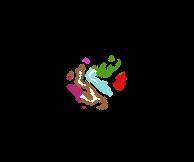

In [84]:
__create_plot(False,rotated.astype(np.uint8),'',color_range=color_range)

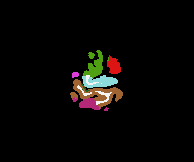

In [83]:
__create_plot(False,mask.astype(np.uint8),'',color_range=color_range)

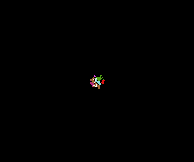

In [142]:
__create_plot(False,zoomed_and_rotated_image.astype(np.uint8),'',color_range=color_range)

In [132]:
center

array([81., 97.])

### Zooms

In [8]:
data_dir = '/om2/user/sabeen/nobrainer_data_norm/new_small_no_aug_51'
aug_dir = '/om2/user/sabeen/nobrainer_data_norm/20240202_small_aug_51'
mode = 'test'

In [9]:
images = sorted(glob.glob(f"{data_dir}/{mode}/brain*.npy"))
masks = sorted(glob.glob(f"{data_dir}/{mode}/mask*.npy"))

In [12]:
LABELS_SHAPE = [256, 256,256]
def generate_small_bias(spacing):
    bias_shape_factor = [0.025, 1 / spacing, 0.025]
    bias_field_std = 0.5

    small_bias_size = np.ceil(
        np.multiply(LABELS_SHAPE, bias_shape_factor)
    ).astype(int)

    small_bias = (
        bias_field_std
        * np.random.uniform(size=[1])
        * np.random.normal(size=small_bias_size)
    )

    factors = np.divide(1.0, bias_shape_factor).tolist()

    return small_bias, factors

In [14]:
small_bias, bias_factors = generate_small_bias(2)

In [19]:
bias_factors

[40.0, 2.0, 40.0]

In [199]:
# Calculate the center of the image
center = np.array(mask.shape) / 2.0

# Generate a 2x2 rotation matrix
rotation_angle = 45
rotation_matrix = np.array([[np.cos(np.radians(rotation_angle)), -np.sin(np.radians(rotation_angle))],
                            [np.sin(np.radians(rotation_angle)), np.cos(np.radians(rotation_angle))]])

# Generate a 2x2 scaling matrix
scaling_factor = 2
scaling_matrix = np.array([[scaling_factor, 0], [0, scaling_factor]])

# Combine the transformations into a single affine matrix
combined_affine_matrix = np.dot(rotation_matrix, scaling_matrix)

# Calculate the new center after applying the transformation
new_center = np.dot(scaling_matrix, center)

# Calculate the offset for the affine transformation
offset = center - new_center

# Apply the affine transformation using scipy.ndimage.affine_transform
zoomed_and_rotated_image = affine_transform(mask, scaling_matrix,offset=offset,order=0)

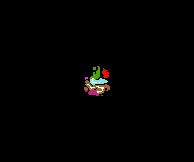

In [200]:
__create_plot(False,zoomed_and_rotated_image.astype(np.uint8),'',color_range=color_range)

In [186]:
# Translate the center back to the origin
translation_matrix1 = np.array([[1, 0, -center[0]],
                                [0, 1, -center[1]],
                                [0, 0, 1]])

# Translate the center to the original position
translation_matrix2 = np.array([[1, 0, center[0]],
                                [0, 1, center[1]],
                                [0, 0, 1]])

In [207]:
rotation_matrix = np.array([[np.cos(np.radians(rotation_angle)), -np.sin(np.radians(rotation_angle)),0],
                            [np.sin(np.radians(rotation_angle)), np.cos(np.radians(rotation_angle)),0],
                            [0,0,1]])

In [213]:
# Generate a 2x2 scaling matrix
scaling_factor = 1/2
scaling_matrix = np.array([[scaling_factor, 0,0], [0, scaling_factor,0],[0,0,1]])

In [214]:
final_matrix = translation_matrix2 @ scaling_matrix @ rotation_matrix @ translation_matrix1

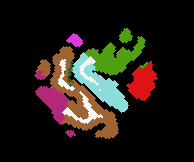

In [215]:
__create_plot(False,affine_transform(mask, final_matrix,order=0),'',color_range=color_range)

In [185]:
new_cent = np.dot(rotation_matrix, [center[0],center[1],0])

In [181]:
off = (center[0] - new_cent[0], center[1] - new_cent[1])

In [263]:
def create_affine_transformation_matrix(
    n_dims, scaling=None, rotation=None, shearing=None, translation=None
):
    """
    From https://github.com/MGH-LEMoN/photo-reconstruction/blob/main/scripts/hcp_replicate_photos.py#L85C40-L85C40.
    Create a 4x4 affine transformation matrix from specified values
    :param n_dims: integer
    :param scaling: list of 3 scaling values
    :param rotation: list of 3 angles (degrees) for rotations around 1st, 2nd, 3rd axis
    :param shearing: list of 6 shearing values
    :param translation: list of 3 values
    :return: 4x4 numpy matrix
    """

    T_scaling = np.eye(n_dims + 1)
    T_shearing = np.eye(n_dims + 1)
    T_translation = np.eye(n_dims + 1)

    if scaling is not None:
        T_scaling[np.arange(n_dims + 1), np.arange(n_dims + 1)] = np.append(
            scaling, 1
        )

    if shearing is not None:
        shearing_index = np.ones((n_dims + 1, n_dims + 1), dtype="bool")
        shearing_index[np.eye(n_dims + 1, dtype="bool")] = False
        shearing_index[-1, :] = np.zeros((n_dims + 1))
        shearing_index[:, -1] = np.zeros((n_dims + 1))
        T_shearing[shearing_index] = shearing

    if translation is not None:
        T_translation[
            np.arange(n_dims), n_dims * np.ones(n_dims, dtype="int")
        ] = translation

    if n_dims == 2:
        if rotation is None:
            rotation = np.zeros(1)
        else:
            rotation = np.asarray(rotation) * (np.pi / 180)
        T_rot = np.eye(n_dims + 1)
        T_rot[np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])] = [
            np.cos(rotation[0]),
            np.sin(rotation[0]),
            np.sin(rotation[0]) * -1,
            np.cos(rotation[0]),
        ]
        return T_translation @ T_rot @ T_shearing @ T_scaling

    else:

        if rotation is None:
            rotation = np.zeros(n_dims)
        else:
            rotation = np.asarray(rotation) * (np.pi / 180)
        T_rot1 = np.eye(n_dims + 1)
        T_rot1[np.array([1, 2, 1, 2]), np.array([1, 1, 2, 2])] = [
            np.cos(rotation[0]),
            np.sin(rotation[0]),
            np.sin(rotation[0]) * -1,
            np.cos(rotation[0]),
        ]
        T_rot2 = np.eye(n_dims + 1)
        T_rot2[np.array([0, 2, 0, 2]), np.array([0, 0, 2, 2])] = [
            np.cos(rotation[1]),
            np.sin(rotation[1]) * -1,
            np.sin(rotation[1]),
            np.cos(rotation[1]),
        ]
        T_rot3 = np.eye(n_dims + 1)
        T_rot3[np.array([0, 1, 0, 1]), np.array([0, 0, 1, 1])] = [
            np.cos(rotation[2]),
            np.sin(rotation[2]),
            np.sin(rotation[2]) * -1,
            np.cos(rotation[2]),
        ]
        return T_translation @ T_rot3 @ T_rot2 @ T_rot1 @ T_shearing @ T_scaling

In [279]:
aff = create_affine_transformation_matrix(n_dims = 2,
                                    scaling = (2,1/2),
                                    rotation = rotation,
                                    shearing = None,
                                    translation = None)

In [280]:
final = translation_matrix2 @ aff @ translation_matrix1

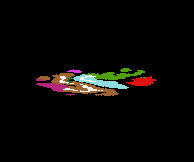

In [281]:
__create_plot(False,affine_transform(mask, final ,order=0),'',color_range=color_range)

In [4]:
# directory where images and masks are stored
data_dir = '/om2/user/sabeen/nobrainer_data_norm/new_small_no_aug_51'

# directory where affine matrices are stored
aug_dir = '/om2/user/sabeen/nobrainer_data_norm/20240217_small_synth_aug'
mode = 'test'

images = sorted(glob.glob(f"{data_dir}/{mode}/brain*.npy"))
masks = sorted(glob.glob(f"{data_dir}/{mode}/mask*.npy"))
affines = sorted(glob.glob(f"{aug_dir}/{mode}/affine*.npy"))

In [5]:
len(images) == len(masks) == len(affines)

True

In [35]:
index = 80
brain = np.load(images[index])[0,:,:]
mask = np.load(masks[index])[0,:,:]
affine = np.load(affines[index])

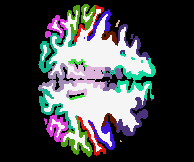

In [51]:
colors = __rgb_map_for_data(51)
color_range = np.zeros((256,3))
color_range[:colors.shape[0],:] = colors

new_mask = np.uint8(affine_transform(mask, affine ,order=0))
__create_plot(False,new_mask,'',color_range=color_range)

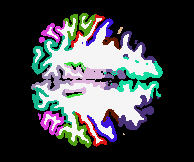

In [52]:
__create_plot(False,np.uint8(mask),'',color_range=color_range)

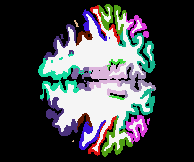

In [68]:
__create_plot(False,np.uint8(torch.flip(torch.from_numpy(new_mask),dims=(1,))),'',color_range=color_range)

<module 'torch' from '/om2/user/sabeen/miniconda/lib/python3.9/site-packages/torch/__init__.py'>

In [16]:
np.uint8(affine_transform(mask, affine ,order=0)).shape

(1, 162, 194)

In [48]:
new_affine_matrix = np.eye(3)

# Scale the x-axis by -1 to achieve horizontal flip
new_affine_matrix[0, 0] *= -1

In [69]:
torch.flip(torch.from_numpy(new_mask),dims=(1,))

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

# Albumentations

In [5]:
import sys
import os
import glob
import json

import numpy as np
import random
import albumentations as A

sys.path.append("../")
from TissueLabeling.brain_utils import mapping, load_brains

In [5]:
SOURCE_DIR_00 = "/om2/scratch/tmp/sabeen/kwyk_data/kwyk/rawdata/"

# TRANSFORM_DIR = '/om2/user/sabeen/kwyk_data/kwyk_transform_crop_1000'
TRANSFORM_DIR = SOURCE_DIR_00
FEATURE_TRANFORM_DIR = (
    f"{TRANSFORM_DIR}/features" if TRANSFORM_DIR != SOURCE_DIR_00 else SOURCE_DIR_00
)
LABEL_TRANFORM_DIR = (
    f"{TRANSFORM_DIR}/labels" if TRANSFORM_DIR != SOURCE_DIR_00 else SOURCE_DIR_00
)

In [6]:
data_dir = '/om2/scratch/tmp/sabeen/kwyk_data/kwyk_final_uncrop/'
mode = 'train'
background_percent_cutoff = 0.8
valid_feature_filename = f"{data_dir}/{mode}/valid_feature_files_{int(background_percent_cutoff*100)}.json"
valid_label_filename = f"{data_dir}/{mode}/valid_label_files_{int(background_percent_cutoff*100)}.json"
with open(valid_feature_filename) as f:
    images = json.load(f)
with open(valid_label_filename) as f:
    masks = json.load(f)

In [7]:
ind = random.randint(0,len(masks))

In [8]:
image = np.load(images[ind])
mask = np.load(masks[ind]).astype('int16')

In [9]:
mask, class_mapping = mapping(mask,nr_of_classes=50,reference_col="original", class_mapping=None)

In [10]:
transform = A.Compose([
    A.Affine(rotate=(-15,15),scale=(1-0.2,1+0.2),shear=(-0.69,0.69)),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ElasticTransform(),
])

In [11]:
transformed = transform(image = image[0,:,:].astype(np.float32), mask = mask[0,:,:])
transformed_image = transformed['image']
transformed_mask = transformed['mask']

In [14]:
colors = __rgb_map_for_data(50)
color_range = np.zeros((256,3))
color_range[:colors.shape[0],:] = colors

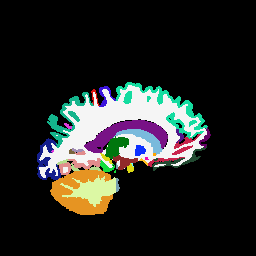

In [15]:
__create_plot(False,np.uint8(mask[0,:,:]),'',color_range=color_range)

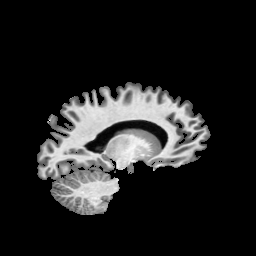

In [16]:
__create_plot(False,np.uint8(image[0,:,:] * 255),'',)

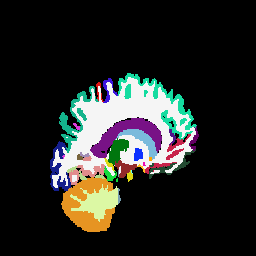

In [17]:
__create_plot(False,np.uint8(transformed_mask),'',color_range=color_range)

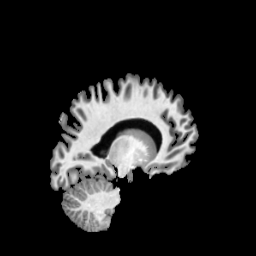

In [18]:
__create_plot(False,np.uint(transformed_image * 255),'')

In [12]:
(image[0,:,:]== transformed_image).all()

False

In [80]:
import numpy as np

def add_random_shapes(arr):
    height, width = arr.shape
    
    # Generate random shapes
    num_shapes = np.random.randint(1, 5)  # Randomly choose 1 to 4 shapes to add
    for _ in range(num_shapes):
        shape_type = np.random.choice(['rectangle', 'circle', 'ellipse'])  # Randomly choose shape type
        
        # Randomly generate shape parameters
        if shape_type == 'rectangle':
            x1, y1 = np.random.randint(0, width), np.random.randint(0, height)
            x2, y2 = np.random.randint(x1, width), np.random.randint(y1, height)
            color = np.random.randint(0, 256)  # Random color value
            arr[y1:y2, x1:x2] = color  # Fill the rectangle with random color
        elif shape_type == 'circle':
            center_x, center_y = np.random.randint(0, width), np.random.randint(0, height)
            radius = np.random.randint(10, min(height, width) // 4)  # Random radius
            color = np.random.randint(0, 256)  # Random color value
            y, x = np.ogrid[-center_y:height-center_y, -center_x:width-center_x]
            mask = x**2 + y**2 <= radius**2
            arr[mask] = color  # Fill the circle with random color
        elif shape_type == 'ellipse':
            center_x, center_y = np.random.randint(0, width), np.random.randint(0, height)
            semi_major_axis = np.random.randint(10, min(height, width) // 8)  # Random semi-major axis
            semi_minor_axis = np.random.randint(10, min(height, width) // 8)  # Random semi-minor axis
            rotation_angle = np.random.randint(0, 360)  # Random rotation angle
            color = np.random.randint(0, 256)  # Random color value
            y, x = np.ogrid[-center_y:height-center_y, -center_x:width-center_x]
            mask = (((x * np.cos(np.radians(rotation_angle)) + y * np.sin(np.radians(rotation_angle))) ** 2) / semi_major_axis ** 2 +
                    ((y * np.cos(np.radians(rotation_angle)) - x * np.sin(np.radians(rotation_angle))) ** 2) / semi_minor_axis ** 2) <= 1
            arr[mask] = color  # Fill the ellipse with random color

    return arr

# Example usage:
arr = np.zeros((256, 256), dtype=np.uint8)  # Create a 256x256 array filled with zeros
result = add_random_shapes(arr.copy())  # Add random shapes to the array

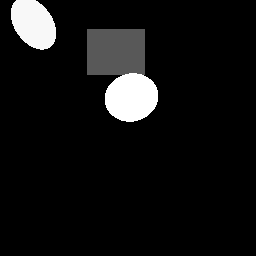

In [21]:
__create_plot(False,np.uint(add_random_shapes(arr.copy())),'')

In [22]:
import cv2
import numpy as np

def draw_random_shapes_cv2(shape=(256, 256), num_shapes=5):
    canvas = np.zeros(shape, dtype=np.uint8)  # Create a blank canvas
    
    for _ in range(num_shapes):
        shape_type = np.random.choice(['line', 'rectangle', 'circle', 'ellipse', 'polygon'])
        color = np.random.randint(0,255)  # Random intensity value between 0 and 1
        
        if shape_type == 'line':
            pt1 = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
            pt2 = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
            cv2.line(canvas, pt1, pt2, color, thickness=np.random.randint(1, 5))
        elif shape_type == 'rectangle':
            pt1 = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
            pt2 = (np.random.randint(pt1[0], shape[1]), np.random.randint(pt1[1], shape[0]))
            cv2.rectangle(canvas, pt1, pt2, color, thickness=-1)#np.random.randint(1, 5))
        elif shape_type == 'circle':
            center = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
            radius = np.random.randint(10, min(shape) // 4)
            cv2.circle(canvas, center, radius, color, thickness=-1)#np.random.randint(1, 5))
        elif shape_type == 'ellipse':
            center = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
            axes = (np.random.randint(10, min(shape) // 4), np.random.randint(10, min(shape) // 4))
            angle = np.random.randint(0, 180)
            cv2.ellipse(canvas, center, axes, angle, 0, 360, color, thickness=-1)#np.random.randint(1, 5))
        elif shape_type == 'polygon':
            num_vertices = np.random.randint(3, 10)
            vertices = np.random.randint(0, shape[1], size=(num_vertices, 2))
            vertices = vertices.reshape((-1, 1, 2))
            cv2.polylines(canvas, [vertices], isClosed=True, color=color, thickness=np.random.randint(1, 5))

    return canvas.astype(np.float32) / 255.0  # Normalize to range [0, 1]

# Example usage:
result = draw_random_shapes_cv2()

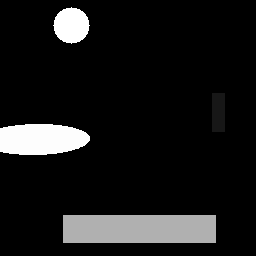

In [23]:
__create_plot(False,np.uint(draw_random_shapes_cv2(shape=(256,256),num_shapes=random.randint(0,6))*255),'')

148

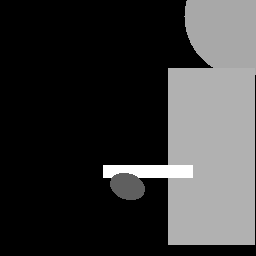

In [83]:
result = add_random_shapes(image[0,:,:].copy())  # Add random shapes to the array
__create_plot(False,np.uint(result),'')

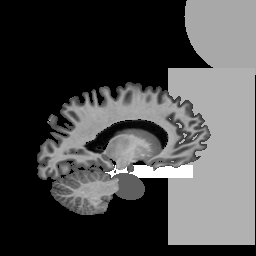

In [84]:
combined = np.where(mask[0,:,:] == 0, result/255, image[0,:,:])
__create_plot(False,np.uint(combined * 255),'')

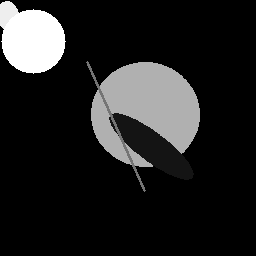

In [92]:
result2 = draw_random_shapes_cv2(shape=(256,256),num_shapes=random.randint(1,5))
__create_plot(False,np.uint(result2*255),'')

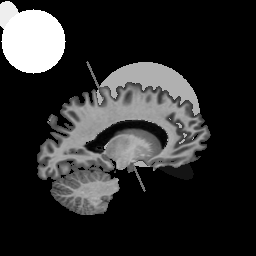

In [93]:
combined2 = np.where(mask[0,:,:] == 0, result2, image[0,:,:])
__create_plot(False,np.uint(combined2 * 255),'')

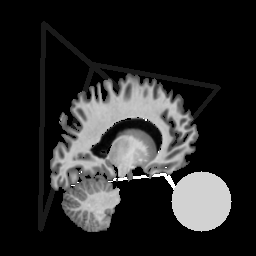

In [74]:
combined2_transformed = np.where(transformed_mask == 0, result2, transformed_image[:,:])
__create_plot(False,np.uint(combined2_transformed * 255),'')

(256, 256)

In [118]:
def generate_random_grid_pattern(shape=(256, 256), intensity_range=(0,1), thickness_range=(1, 5), spacing_range=(5, 20)):
    background_intensity = np.random.uniform(*intensity_range)  # Random background intensity
    line_intensity = np.random.uniform(*intensity_range)  # Random line intensity
    line_thickness = np.random.randint(*thickness_range)  # Random line thickness
    grid_spacing = np.random.randint(*spacing_range)  # Random grid spacing
    
    canvas = np.ones(shape, dtype=np.float32) * background_intensity  # Fill the canvas with the background intensity
    
    # Create horizontal lines
    canvas[::grid_spacing, :] = line_intensity
    
    # Create vertical lines
    canvas[:, ::grid_spacing] = line_intensity
    
    return canvas, background_intensity, line_intensity, line_thickness, grid_spacing

0.42879545606644576 0.9847190901992515 1 10


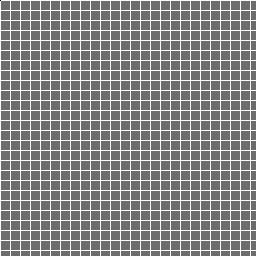

In [143]:
grid_result, background_intensity, line_intensity, line_thickness, grid_spacing = generate_random_grid_pattern()
grid_result[0,0] = 0
grid_result[0,1] = 1
print(background_intensity, line_intensity, line_thickness, grid_spacing )
__create_plot(False,np.uint(grid_result*255),'')

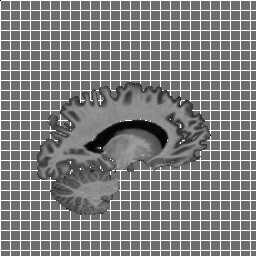

In [144]:
combined_grid = np.where(mask[0,:,:] == 0, grid_result, image[0,:,:])
__create_plot(False,np.uint(combined_grid * 255),'')

# Paper Figures

In [5]:
import sys
import os
import glob
import json

import numpy as np
import random
import albumentations as A

sys.path.append("../")
from TissueLabeling.brain_utils import mapping, load_brains, null_cerebellum_brain_stem, null_half

## Simple Augmentations

In [ ]:
colors = __rgb_map_for_data(50)
color_range = np.zeros((256,3))
color_range[:colors.shape[0],:] = colors

# load always the same image from validation set
image_file = "pac_36_orig.nii.gz"
mask_file = "pac_36_aseg.nii.gz"
file_path = "/nese/mit/group/sig/users/matth406/nobrainer_data/data/SharedData/segmentation/freesurfer_asegs/"
brain, mask, _ = load_brains(image_file, mask_file, file_path)
mask,class_mapping = mapping(mask, nr_of_classes=50, class_mapping=None)

slice_idx = [125, 150]
slice_id = slice_idx[0]
image_dir0 = brain[slice_id,:,:]
mask_dir0 = mask[slice_id,:,:]
image_dir1 = brain[:,slice_id,:]
mask_dir1 = mask[:,slice_id,:]
image_dir2 = brain[:,:,slice_id]
mask_dir2 = mask[:,:,slice_id]

In [30]:
rot_transform = A.Compose([
    A.Affine(rotate=(-15,15),scale=None,shear=None,always_apply=True),
    # A.HorizontalFlip(),
    # A.RandomBrightnessContrast(),
    # A.ElasticTransform(),
])

In [35]:
rot_img_mask = rot_transform(image = image_dir0.astype(np.float32), mask = mask_dir0)
rot_img = rot_img_mask['image']
rot_mask = rot_img_mask['mask']

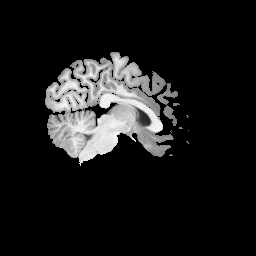

In [72]:
plot_img = image_dir0.copy()
plot_img[0][0] = 0
plot_img[0][1] = 1
__create_plot(False,np.uint(plot_img),'')

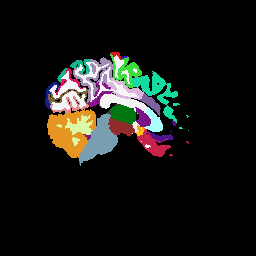

In [11]:
__create_plot(False,np.uint8(mask_dir0),'',color_range=color_range)

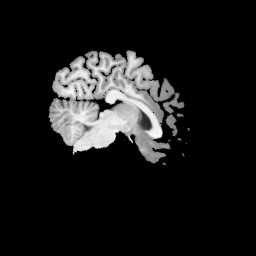

In [39]:
__create_plot(False,np.uint(rot_img),'')

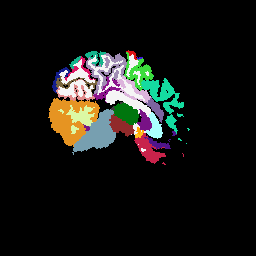

In [36]:
__create_plot(False,np.uint8(rot_mask),'',color_range=color_range)

In [53]:
scale_transform = A.Compose([
    A.Affine(rotate=None,scale=(1-0.2,1+0.2),shear=None,always_apply=True),
    # A.HorizontalFlip(),
    # A.RandomBrightnessContrast(),
    # A.ElasticTransform(),
])
scale_img_mask = scale_transform(image = (image_dir0/255.0).astype(np.float32), mask = mask_dir0)
scale_img = scale_img_mask['image']
scale_mask = scale_img_mask['mask']

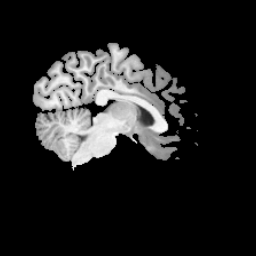

In [54]:
__create_plot(False,np.uint(scale_img*255),'')

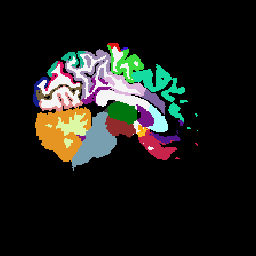

In [55]:
__create_plot(False,np.uint8(scale_mask),'',color_range=color_range)

In [59]:
shear_transform = A.Compose([
    A.Affine(rotate=None,scale=None,shear=(-0.69,0.69),always_apply=True),
    # A.HorizontalFlip(),
    # A.RandomBrightnessContrast(),
    # A.ElasticTransform(),
])
shear_img_mask = shear_transform(image = (image_dir0/255.0).astype(np.float32), mask = mask_dir0)
shear_img = shear_img_mask['image']
shear_mask = shear_img_mask['mask']

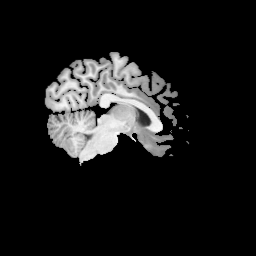

In [60]:
__create_plot(False,np.uint(shear_img*255),'')

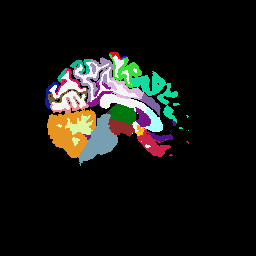

In [61]:
__create_plot(False,np.uint8(shear_mask),'',color_range=color_range)

In [62]:
flip_transform = A.Compose([
    # A.Affine(rotate=None,scale=None,shear=(-0.69,0.69),always_apply=True),
    A.HorizontalFlip(p=1),
    # A.RandomBrightnessContrast(),
    # A.ElasticTransform(),
])
flip_img_mask = flip_transform(image = (image_dir0/255.0).astype(np.float32), mask = mask_dir0)
flip_img = flip_img_mask['image']
flip_mask = flip_img_mask['mask']

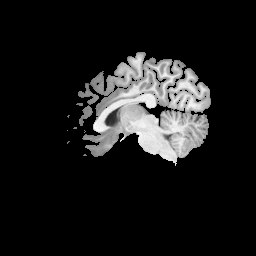

In [63]:
__create_plot(False,np.uint(flip_img*255),'')

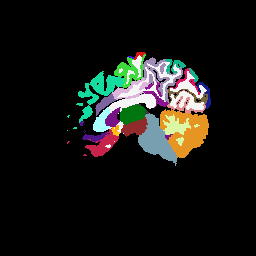

In [64]:
__create_plot(False,np.uint8(flip_mask),'',color_range=color_range)

In [66]:
int_transform = A.Compose([
    # A.Affine(rotate=None,scale=None,shear=(-0.69,0.69),always_apply=True),
    # A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(always_apply=True),
    # A.ElasticTransform(),
])
int_img_mask = int_transform(image = (image_dir0/255.0).astype(np.float32), mask = mask_dir0)
int_img = int_img_mask['image']
int_mask = int_img_mask['mask']

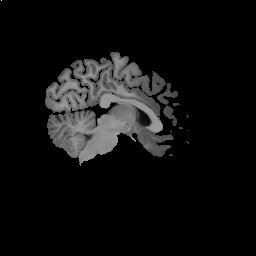

In [69]:
int_img[0][0] = 0
int_img[0][1] = 1
__create_plot(False,np.uint(int_img*255),'')

## Complex Augmentations

In [52]:
colors = __rgb_map_for_data(50)
color_range = np.zeros((256,3))
color_range[:colors.shape[0],:] = colors

# load always the same image from validation set
image_file = "pac_36_orig.nii.gz"
mask_file = "pac_36_aseg.nii.gz"
file_path = "/nese/mit/group/sig/users/matth406/nobrainer_data/data/SharedData/segmentation/freesurfer_asegs/"
brain, mask, _ = load_brains(image_file, mask_file, file_path)
# mask,class_mapping = mapping(mask, nr_of_classes=50, class_mapping=None)

slice_idx = [125, 150]
slice_id = slice_idx[0]
image_dir0 = brain[slice_id,:,:]
mask_dir0 = mask[slice_id,:,:]
image_dir1 = brain[:,slice_id,:]
mask_dir1 = mask[:,slice_id,:]
image_dir2 = brain[:,:,slice_id]
mask_dir2 = mask[:,:,slice_id]

In [61]:
feature_slice = image_dir1.copy()
label_slice = mask_dir1.copy()
feature_slice, label_slice, right_classes, left_classes = null_half(image=feature_slice, mask=label_slice, keep_left=False,right_classes=None,left_classes=None)
# feature_slice, label_slice, null_classes = null_cerebellum_brain_stem(image=feature_slice, mask=label_slice,null_classes=None)

In [54]:
label_slice, _ = mapping(label_slice, nr_of_classes=50, reference_col='original', class_mapping=None)

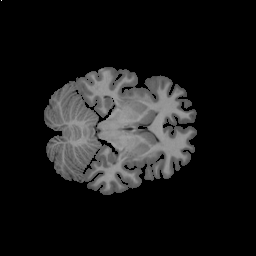

In [48]:
plot_img = image_dir1.copy() / 255.0
plot_img[0][0] = 0
plot_img[0][1] = 1
__create_plot(False,np.uint(plot_img * 255),'')

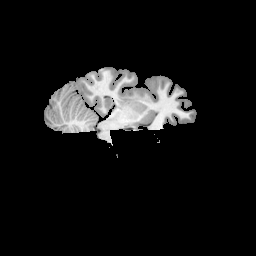

In [62]:
# feature_slice = feature_slice / 255.0
# feature_slice[0,0] = 0
# feature_slice[0,1] = 1
# feature_slice = feature_slice * 255.0
__create_plot(False,np.uint8(feature_slice),'')

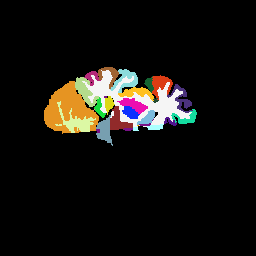

In [50]:
__create_plot(False,np.uint8(label_slice),'',color_range=color_range)

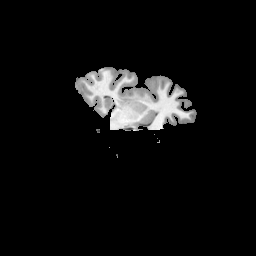

In [60]:
# feature_slice = feature_slice / 255.0
# feature_slice[0,0] = 0
# feature_slice[0,1] = 1
# feature_slice = feature_slice * 255.0
__create_plot(False,np.uint8(feature_slice),'')

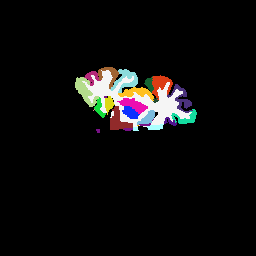

In [56]:
__create_plot(False,np.uint8(label_slice),'',color_range=color_range)